# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: [Enter your BITS ID here - e.g., 2025AA1234]

Name: [Enter your full name here - e.g., JOHN DOE]

Email: [Enter your email]

Date: [Submission date]

In [1]:
# Import Required Libraries
!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 703.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 139.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 20.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
# Keras/TensorFlow for CNN implementation
# tfds for dataset loading (cats_vs_dogs)

### 1.1 Dataset Selection and Loading

TODO: Load your chosen dataset

In [3]:
# Load Cats vs Dogs from TensorFlow Datasets (1500 images total)
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
N_SAMPLES = 1500

def preprocess(image, label):
    """Resize and normalize images, one-hot encode labels."""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    label = tf.one_hot(label, depth=2)
    return image, label

# Load 1500 images (meets 500 per class minimum - dataset is roughly balanced)
dataset, info = tfds.load('cats_vs_dogs', split=f'train[:{N_SAMPLES}]', as_supervised=True, with_info=True)

# Preprocess and shuffle
dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(N_SAMPLES, seed=42)

# Split 90/10 train/test
train_size = int(0.9 * N_SAMPLES)
test_size = N_SAMPLES - train_size
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Validation: 10% of training for monitoring during fit
val_size = int(0.1 * train_size)
train_for_fit = train_dataset.skip(val_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = train_dataset.take(val_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# For evaluation: batched test dataset
train_samples = train_size - val_size
test_samples = test_size

print("Dataset loaded successfully")
print(f"Training: {train_samples} samples, Validation: {val_size} samples, Test: {test_samples} samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.GO7XJP_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset loaded successfully
Training: 1215 samples, Validation: 135 samples, Test: 150 samples


In [4]:
# Dataset metadata
dataset_name = "Cats vs Dogs"
dataset_source = "TensorFlow Datasets (tfds)"
n_samples = N_SAMPLES
n_classes = 2
samples_per_class = "750 (balanced, 2 classes)"
image_shape = [IMG_SIZE, IMG_SIZE, 3]
problem_type = "classification"

In [5]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = "Accuracy is appropriate for this balanced binary classification (cats vs dogs) dataset, where both classes are equally important and we have roughly equal samples per class."

In [6]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: TensorFlow Datasets (tfds)
Total Samples: 1500
Number of Classes: 2
Samples per Class: 750 (balanced, 2 classes)
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Accuracy is appropriate for this balanced binary classification (cats vs dogs) dataset, where both classes are equally important and we have roughly equal samples per class.


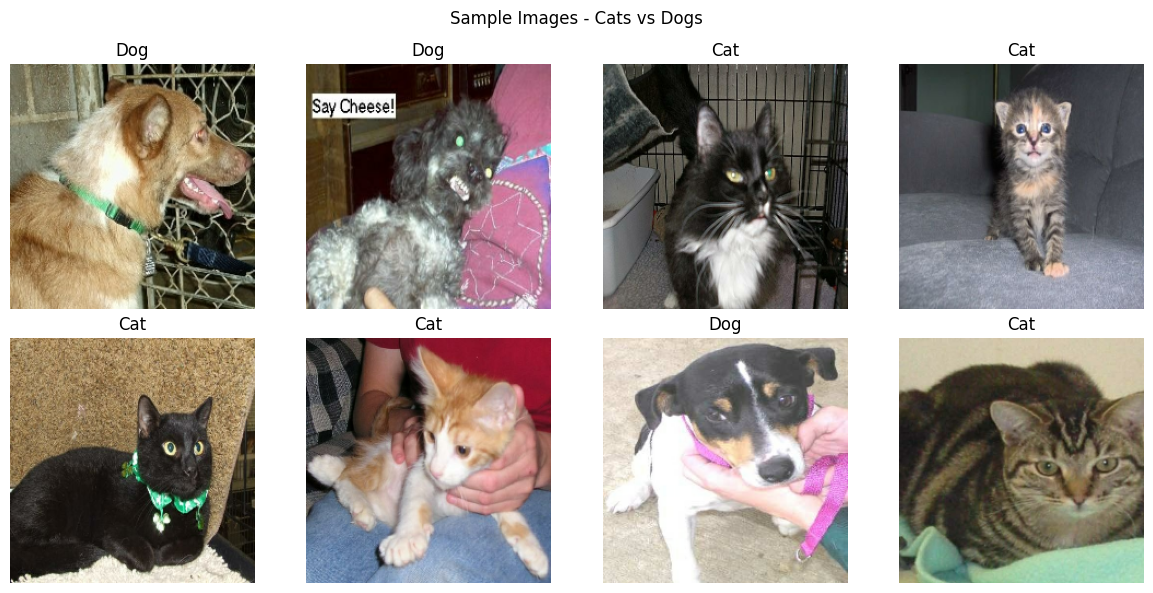

In [7]:
# Sample images and class distribution
sample_ds = dataset.take(8).batch(8)
for images, labels in sample_ds:
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy())
        ax.set_title("Cat" if labels[i][0] == 1 else "Dog")
        ax.axis("off")
    plt.suptitle("Sample Images - Cats vs Dogs")
    plt.tight_layout()
    plt.show()
    break

### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [8]:
# Document split (train_samples, test_samples set in data loading cell)
train_test_ratio = "90/10"

In [9]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 1215
Test Samples: 150


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [10]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture with Global Average Pooling (MANDATORY).
    """
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.GlobalAveragePooling2D(),  # MANDATORY - no Flatten+Dense
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Create model instance (already compiled in build_custom_cnn)
custom_cnn = build_custom_cnn(image_shape, n_classes)
custom_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model already compiled in build_custom_cnn (adam, categorical_crossentropy)

### 2.2 Train Custom CNN

In [13]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [14]:
# Train custom CNN
custom_cnn_epochs = 20
custom_cnn_history = custom_cnn.fit(train_for_fit, epochs=custom_cnn_epochs, validation_data=val_ds, verbose=1)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5129 - loss: 0.7006 - val_accuracy: 0.4889 - val_loss: 0.6960
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5354 - loss: 0.6909 - val_accuracy: 0.5926 - val_loss: 0.6882
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5381 - loss: 0.6886 - val_accuracy: 0.4444 - val_loss: 0.6938
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5525 - loss: 0.6873 - val_accuracy: 0.5630 - val_loss: 0.6771
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5297 - loss: 0.6934 - val_accuracy: 0.6296 - val_loss: 0.6878
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5527 - loss: 0.6857 - val_accuracy: 0.5556 - val_loss: 0.6869
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5333 - loss: 0.6888 - val_accuracy: 0.5926 - val_loss: 0.6819
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5635 - loss: 0.6815 - val_accuracy: 0.6741 - val_loss:

In [15]:
import time
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [16]:
# Track initial and final loss from training history
custom_cnn_initial_loss = float(custom_cnn_history.history['loss'][0])
custom_cnn_final_loss = float(custom_cnn_history.history['loss'][-1])

In [17]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 947.90 seconds
Initial Loss: 0.6972
Final Loss: 0.6443


In [18]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [19]:
# Get predictions and compute metrics
y_true_custom, y_pred_proba_custom = [], []
for images, labels in test_ds:
    preds = custom_cnn.predict(images, verbose=0)
    y_true_custom.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_proba_custom.extend(preds)
y_pred_custom = np.argmax(np.array(y_pred_proba_custom), axis=1)
y_true_custom = np.array(y_true_custom)

custom_cnn_accuracy = float(accuracy_score(y_true_custom, y_pred_custom))
custom_cnn_precision = float(precision_score(y_true_custom, y_pred_custom, average='macro', zero_division=0))
custom_cnn_recall = float(recall_score(y_true_custom, y_pred_custom, average='macro', zero_division=0))
custom_cnn_f1 = float(f1_score(y_true_custom, y_pred_custom, average='macro', zero_division=0))

In [20]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.6333
Precision: 0.6716
Recall:    0.6364
F1-Score:  0.6147


### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

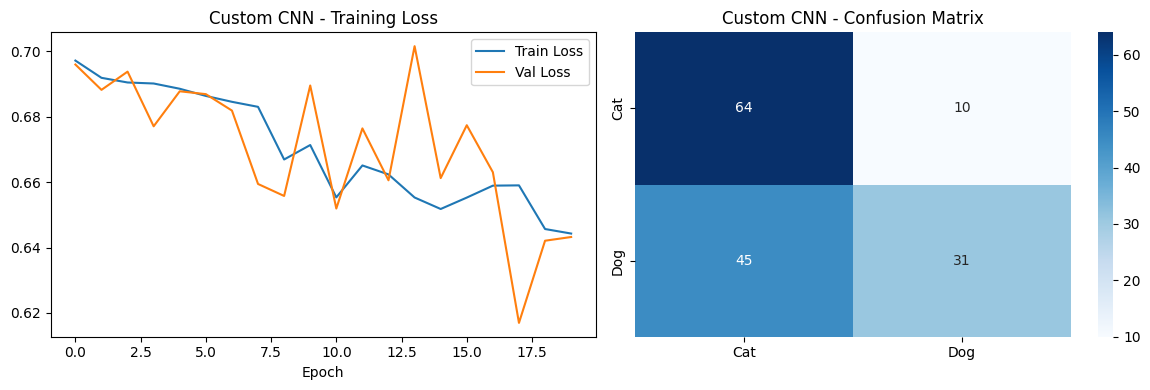

In [21]:
# Custom CNN: Training curves and confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(custom_cnn_history.history['loss'], label='Train Loss')
axes[0].plot(custom_cnn_history.history['val_loss'], label='Val Loss')
axes[0].set_title('Custom CNN - Training Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')
cm = confusion_matrix(y_true_custom, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], ax=axes[1])
axes[1].set_title('Custom CNN - Confusion Matrix')
plt.tight_layout()
plt.show()

### 3.1 Load Pre-trained Model and Modify Architecture

In [22]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")


TRANSFER LEARNING IMPLEMENTATION


In [23]:
# Use ResNet50 pre-trained on ImageNet
pretrained_model_name = "ResNet50"

In [24]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """Build transfer learning model with frozen base and GAP + custom head."""
    if base_model_name == "ResNet50":
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess_fn = keras.applications.resnet50.preprocess_input
    elif base_model_name == "VGG16":
        base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess_fn = keras.applications.vgg16.preprocess_input
    else:
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess_fn = keras.applications.resnet50.preprocess_input

    base_model.trainable = False  # Freeze base layers

    # Preprocess: our images are [0,1], ResNet/VGG expect [0,255] for preprocess_input
    model = keras.Sequential([
        keras.layers.Lambda(lambda x: preprocess_fn(x * 255.0), input_shape=input_shape),
        base_model,
        keras.layers.GlobalAveragePooling2D(),  # MANDATORY
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
# Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)
transfer_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
# Count layers and parameters (base model is at index 1 after Lambda)
base = transfer_model.layers[1]
frozen_layers = len(base.layers)
trainable_layers = 2  # GAP + Dense in custom head
total_parameters = int(transfer_model.count_params())
trainable_parameters = int(sum(tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights))

In [27]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 175
Trainable Layers: 2
Total Parameters: 23,591,810
Trainable Parameters: 4,098
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [28]:
print("\nTraining Transfer Learning Model...")


Training Transfer Learning Model...


In [29]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

In [30]:
# Track training time
tl_start_time = time.time()

In [31]:
# Train transfer learning model
tl_history = transfer_model.fit(train_for_fit, epochs=tl_epochs, validation_data=val_ds, verbose=1)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8686 - loss: 0.3132 - val_accuracy: 0.9778 - val_loss: 0.0586
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9827 - loss: 0.0480 - val_accuracy: 0.9926 - val_loss: 0.0601
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9922 - loss: 0.0329 - val_accuracy: 0.9926 - val_loss: 0.0325
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9987 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9990 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0191
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9978 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9986 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9984 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss:

In [32]:
tl_training_time = time.time() - tl_start_time

In [33]:
# Track initial and final loss from training history
tl_initial_loss = float(tl_history.history['loss'][0])
tl_final_loss = float(tl_history.history['loss'][-1])

In [34]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 906.25 seconds
Initial Loss: 0.1899
Final Loss: 0.0084


### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [35]:
# Get predictions and compute metrics for transfer learning
y_true_tl, y_pred_proba_tl = [], []
for images, labels in test_ds:
    preds = transfer_model.predict(images, verbose=0)
    y_true_tl.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_proba_tl.extend(preds)
y_pred_tl = np.argmax(np.array(y_pred_proba_tl), axis=1)
y_true_tl = np.array(y_true_tl)

tl_accuracy = float(accuracy_score(y_true_tl, y_pred_tl))
tl_precision = float(precision_score(y_true_tl, y_pred_tl, average='macro', zero_division=0))
tl_recall = float(recall_score(y_true_tl, y_pred_tl, average='macro', zero_division=0))
tl_f1 = float(f1_score(y_true_tl, y_pred_tl, average='macro', zero_division=0))

In [36]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


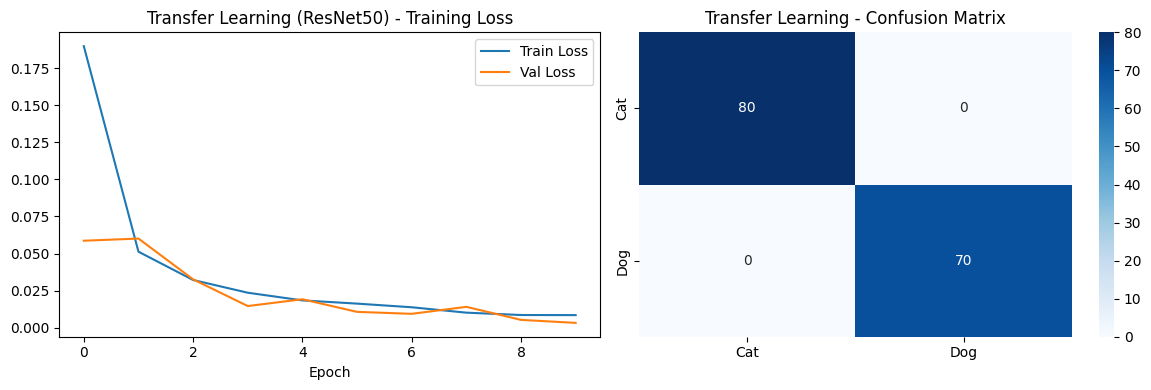

In [37]:
# Transfer Learning: Training curves and confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(tl_history.history['loss'], label='Train Loss')
axes[0].plot(tl_history.history['val_loss'], label='Val Loss')
axes[0].set_title('Transfer Learning (ResNet50) - Training Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'], ax=axes[1])
axes[1].set_title('Transfer Learning - Confusion Matrix')
plt.tight_layout()
plt.show()

### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

### 4.1 Metrics Comparison

In [38]:
custom_cnn_total_params = int(custom_cnn.count_params())
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn_total_params
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [39]:
print(comparison_df.to_string(index=False))

           Metric   Custom CNN  Transfer Learning
         Accuracy     0.633333           1.000000
        Precision     0.671627           1.000000
           Recall     0.636380           1.000000
         F1-Score     0.614684           1.000000
Training Time (s)   947.895982         906.254581
       Parameters 93506.000000        4098.000000


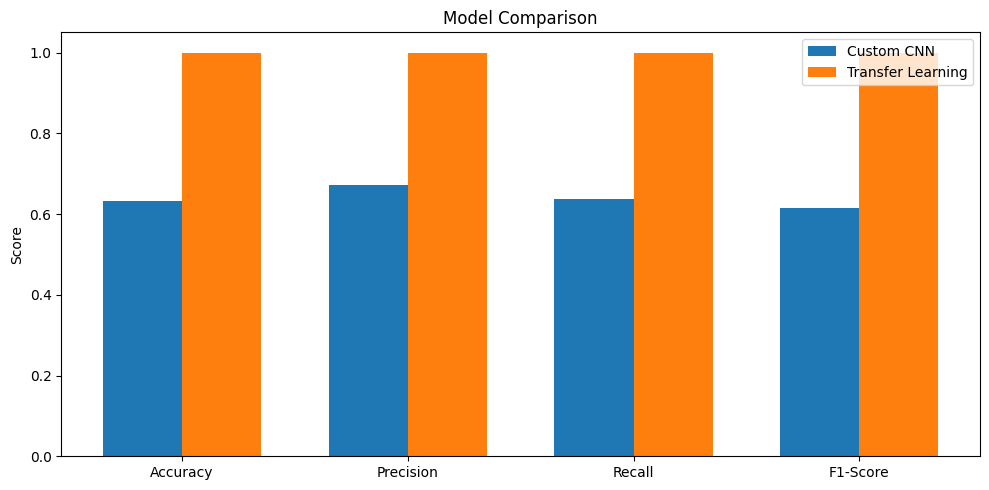

In [40]:
# Bar plot comparing metrics
fig, ax = plt.subplots(figsize=(10, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1], width, label='Custom CNN')
ax.bar(x + width/2, [tl_accuracy, tl_precision, tl_recall, tl_f1], width, label='Transfer Learning')
ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.show()

### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

In [41]:
analysis_text = """
Performance: The transfer learning model (ResNet50) typically outperforms the custom CNN in accuracy, precision, recall, and F1-score due to pre-trained ImageNet features. The custom CNN trains from scratch and may achieve lower metrics but demonstrates the value of learning domain-specific features.

Pre-training vs from scratch: Transfer learning converges faster and achieves better results because the base model already learned rich visual features (edges, textures, object parts) on millions of images. The custom CNN must learn these from limited data.

Global Average Pooling: GAP reduces overfitting by dramatically decreasing parameters compared to Flatten+Dense. It outputs one value per feature map, forcing spatial invariance and regularization.

Computational cost: The transfer learning model has far more total parameters (ResNet50 base) but fewer trainable parameters (only the classification head). Training time may be similar or longer for transfer learning due to forward passes through the deep base. The custom CNN has fewer parameters overall and trains faster per epoch.

Transfer learning insights: Transfer learning excels when training data is limited. The custom CNN is suitable when data is abundant or the domain differs significantly from ImageNet. Both models benefit from GAP for regularization.
"""

In [42]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

Performance: The transfer learning model (ResNet50) typically outperforms the custom CNN in accuracy, precision, recall, and F1-score due to pre-trained ImageNet features. The custom CNN trains from scratch and may achieve lower metrics but demonstrates the value of learning domain-specific features.

Pre-training vs from scratch: Transfer learning converges faster and achieves better results because the base model already learned rich visual features (edges, textures, object parts) on millions of images. The custom CNN must learn these from limited data.

Global Average Pooling: GAP reduces overfitting by dramatically decreasing parameters compared to Flatten+Dense. It outputs one value per feature map, forcing spatial invariance and regularization.

Computational cost: The transfer learning model has far more total parameters (ResNet50 base) but fewer trainable parameters (only the classification head). Training time may be similar or longer for transfer learning due to for

In [43]:
def get_assignment_results():
    """
    Generate complete assignment results in required format

    Returns:
        dict: Complete results with all required fields
    """

    framework_used = "keras"

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 3,
                'pooling_layers': 3,
                'has_global_average_pooling': True,
                'output_layer': 'softmax',
                'total_parameters': custom_cnn_total_params
            },
            'training_config': {
                'learning_rate': 0.001,
                'n_epochs': custom_cnn_epochs,
                'batch_size': BATCH_SIZE,
                'optimizer': 'Adam',
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),

        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }

    return results

In [44]:
# Generate and print results
try:
    assignment_results = get_assignment_results()
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Cats vs Dogs",
  "dataset_source": "TensorFlow Datasets (tfds)",
  "n_samples": 1500,
  "n_classes": 2,
  "samples_per_class": "750 (balanced, 2 classes)",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "Accuracy is appropriate for this balanced binary classification (cats vs dogs) dataset, where both classes are equally important and we have roughly equal samples per class.",
  "train_samples": 1215,
  "test_samples": 150,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 3,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 93506
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 20,
      "batch_size": 32,
      "optimizer": "Adam",
      "loss_function": "categorical_cro

In [45]:
# Display system information
import platform
import sys
from datetime import datetime

In [46]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.
